# Assignment 9: Hypothesis Testing (Part 1)

## Objective

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


## Task 1. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.


![](img/ab-testing.png)

## Is the number of searches per user different?

The provided [searchlog.json](searchlog.json) has information about users' usage.

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [6]:
#<-- Write Your Code -->
import pandas as pd

# import searchlog.json file
df = pd.read_json('searchlog.json', lines=True)

# Group by search_ui == A and compute the mean over search_count
df_A = df[df['search_ui'] == 'A']
mean_A = df_A['search_count'].mean()

# Group by search_ui == B and compute the mean over search_count
df_B = df[df['search_ui'] == 'B']
mean_B = df_B['search_count'].mean()

# Compute the difference
difference = mean_A - mean_B

difference 
# -0.1350 which tells us that mean_B is greater than mean_A.
#  How can we tell if this is statistically significant?

-0.13500569535052287

Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Our next job is to check whether or not we can reject the null hypothesis. If we can, we adopt the alternative explanation:
 * The difference in the search_count means of Interface A and Interface B are caused by design differences between the two.

To check, we compute the p-value of the observed result. If p-value is below a pre-set threshold (e.g., <0.01), we can reject the null hypothesis, thereby adopting the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

Here is a great video of how to implement the permutation test: https://www.youtube.com/watch?v=Iq9DzN6mvYA&t=489s

In [9]:
#<-- Write Your Code -->

# import ttest_ind from scipy.stats
import numpy as np

num_samples = 10000
ttest_results = []
differences = []

for _ in range(num_samples):
    df_copy = df.copy()
    # permute the search_ui column
    df_copy['search_ui'] = np.random.permutation(df['search_ui'])
    
    df_A_copy = df_copy[df_copy['search_ui'] == 'A']
    df_B_copy = df_copy[df_copy['search_ui'] == 'B']

    # compute the difference and store the values
    mean_A = df_A_copy['search_count'].mean()
    mean_B = df_B_copy['search_count'].mean()
    differences.append(mean_A - mean_B)

# From differences, we can compute the p-value by counting the number of times 
# the difference is greater than the observed difference

# From differences, find the number of times the difference is greater than the observed difference
p_value = np.sum(np.array(differences) > difference) / num_samples
p_value

0.8718

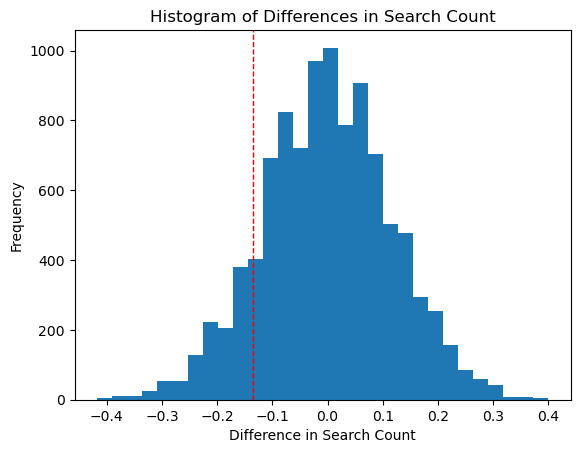

In [10]:
# Graph a histogram of the differences
import matplotlib.pyplot as plt

plt.hist(differences, bins=30)
plt.xlabel('Difference in Search Count')
plt.ylabel('Frequency')
plt.title('Histogram of Differences in Search Count')
plt.axvline(x=difference, color='r', linestyle='dashed', linewidth=1)
plt.show()

Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it?**

**A.** Yes, I would argue that this is a form of p-hacking; however, it's an insightful observation and it is reasonable to think that we should follow this line of inquiry.

To deal with the issue of p-hacking, we could run the analysis on the original data to see if we find statistical significance. If we find the result to be significant, we should **aquire more data** and see if the result still holds **on the same level of significance**. If it does, then we can be confident in our results.

## Task 2. Chi-squared Test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-squared test</a>, <a href="https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squared test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated.

Please write code to compute the Chi-squared stat. Note that you are **not** allowed to call an existing function (e.g., stats.chi2, chi2_contingency). 

In [20]:
#<-- Write Your Code -->

# Compute the count of is_instructor == True for search_ui == A and search_ui == B
df_A = df[df['search_ui'] == 'A']
df_B = df[df['search_ui'] == 'B']

count_A_is_instructor = df_A[df_A['is_instructor'] == True].shape[0]
count_B_is_instructor = df_B[df_B['is_instructor'] == True].shape[0]

# Compute the count of is_instructor == False for search_ui == A and search_ui == B
count_A_not_instructor = df_A[df_A['is_instructor'] == False].shape[0]
count_B_not_instructor = df_B[df_B['is_instructor'] == False].shape[0]

# Compute the expected values for count_A_is_instructor and count_B_is_instructor
expected_A_is_instructor = df_A.shape[0] * (count_A_is_instructor + count_B_is_instructor) / df.shape[0]
expected_B_is_instructor = df_B.shape[0] * (count_A_is_instructor + count_B_is_instructor) / df.shape[0]

# Compute the expected values for count_A_not_instructor and count_B_not_instructor
expected_A_not_instructor = df_A.shape[0] * (count_A_not_instructor + count_B_not_instructor) / df.shape[0]
expected_B_not_instructor = df_B.shape[0] * (count_A_not_instructor + count_B_not_instructor) / df.shape[0]

# Compute the chi-squared statistic
chi_squared =   (count_A_is_instructor - expected_A_is_instructor)**2 / expected_A_is_instructor + \
                (count_B_is_instructor - expected_B_is_instructor)**2 / expected_B_is_instructor + \
                (count_A_not_instructor - expected_A_not_instructor)**2 / expected_A_not_instructor + \
                (count_B_not_instructor - expected_B_not_instructor)**2 / expected_B_not_instructor

# print the chi-squared statistic
print(f'The chi-squared statistic is {chi_squared}')

# Obtain the degrees of freedom
degrees_of_freedom = (2 - 1) * (2 - 1)

# print the degrees of freedom
print(f'The degrees of freedom is {degrees_of_freedom}')

print(f'With 1 degree of freedom and a significance level of 0.05, the critical value is 3.841. \nSince the chi-squared statistic ({chi_squared}) is less than the critical value of 3.841, we fail to reject the null hypothesis. \nThis means that the variables are independent (do not influence one another).')


The chi-squared statistic is 0.6731740891275046
The degrees of freedom is 1
With 1 degree of freedom and a significance level of 0.05, the critical value is 3.841. 
Since the chi-squared statistic (0.6731740891275046) is less than the critical value of 3.841, we fail to reject the null hypothesis. 
This means that the variables are independent (do not influence one another).


Please explain how to use Chi-squared test to determine whether `is_instructor` and `search_ui` are correlated. 

**A.**

A chi-squared test is a hypothesis test that is used when you want to determine whether there is a correlation between two categorical variables or not. Example: Gender and Preferred Newspaper, or Gender and Education Level.

Task: Determine whether is_instructor and search_ui are correlated.

Step 1: We need to create a contingency table, which puts the categories of one feature as the index and the categories of the other feature as the columns. The ij's then are the counts of their intersections.

Step 2: We need to compute the expected values for each of the cells.
1. We need to identify the marginal totals and overall total. 
2. The expected frequency for a cell located in the i-th row and j-th column, denoted as Eij is calculated using Eij = (Ri X Cj) / T
3. We can then compute the chi squared value itself which is given by summing over all squares the values (Oij - Eij) ** 2 / Eij. This is the square of the observed value minus the expected value, divided by the expected value.
4. We then need to compute the degrees of freedom, which is given by the formula df = (#rows -1) (#cols -1)
5. We then need to look up the critical value for the chosen p-value and degrees of freedom, and compare to the chi-square value that we obtained. If the chi-square value > critical value, then we can reject the null and conclude that the alternative hypothesis must be true (that the two variables have a relationship). If the chi-square value < critical value, we fail to reject the null hypothesis.

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 9.